# Imports

The first thing we'll need to do is load in the libraries we'll be using. 

In [1]:
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt

import sklearn
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import MaxAbsScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import QuantileTransformer
from sklearn.preprocessing import PowerTransformer

#sb.set_theme(style="darkgrid")
#np.random.seed(0) # set seed for reproducibility

print("Numpy:", np.__version__)
print("Pandas:", pd.__version__)
print("Seaborn:", sb.__version__)

Numpy: 1.20.2
Pandas: 1.2.4
Seaborn: 0.11.1


# Generate data

In [45]:
N_SAMPLES = 10000
BINS      = 30
npr       = np.random.RandomState(304)

In [53]:
df = pd.DataFrame({
    'Exponential' : np.random.exponential(scale=1.0, size=N_SAMPLES) ,
    'Lognormal' : np.random.lognormal(mean=0.0, sigma=1.0, size=N_SAMPLES),
    'Chi-squared': np.random.chisquare(1, size=N_SAMPLES),
    'Weibull' : np.random.weibull(10, size=N_SAMPLES),
    'Gaussian' : np.random.normal(0, 100, N_SAMPLES),
    'Uniform' : np.random.uniform(low=0.0, high=1.0, size=N_SAMPLES),
    'Bimodal' : np.concatenate((npr.normal(loc=100, size=N_SAMPLES//2), npr.normal(loc=105, size=N_SAMPLES//2)), axis = 0)
}
)

In [54]:
assert df["Exponential"].shape[0] == 10000
assert df["Lognormal"].shape[0] == 10000
assert df["Chi-squared"].shape[0] == 10000
assert df["Weibull"].shape[0] == 10000
assert df["Gaussian"].shape[0] == 10000
assert df["Uniform"].shape[0] == 10000
assert df["Bimodal"].shape[0] == 10000
assert df.shape == (10000, 7)

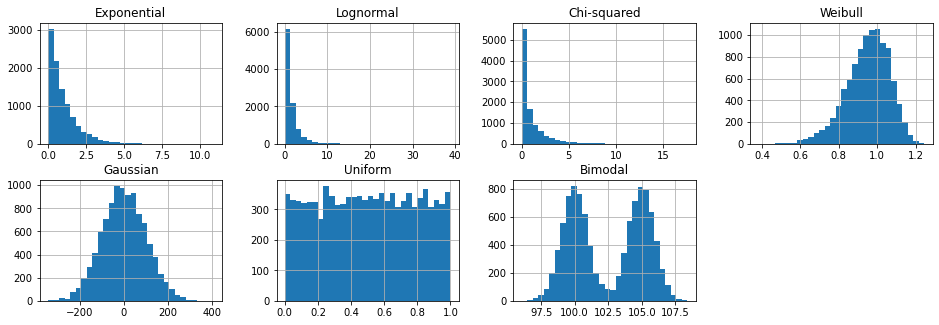

In [55]:
df.hist(bins=BINS, layout=(3, 4), figsize=(16,8));

# Scaling vs. Normalization: What's the difference?

One of the reasons that it's easy to get confused between scaling and normalization is because the terms are sometimes used interchangeably and, to make it even more confusing, they are very similar! In both cases, you're transforming the values of numeric variables so that the transformed data points have specific helpful properties. The difference is that:
- in **scaling**, you're changing the *range* of your data, while 
- in **normalization**, you're changing the *shape of the distribution* of your data. 

Let's talk a little more in-depth about each of these options. 

# Scaling

This means that you're transforming your data so that it fits within a specific scale, like 0-100 or 0-1.  You want to scale data when you're using methods based on measures of how far apart data points are, like [support vector machines (SVM)](https://en.wikipedia.org/wiki/Support_vector_machine) or [k-nearest neighbors (KNN)](https://en.wikipedia.org/wiki/K-nearest_neighbors_algorithm). With these algorithms, a change of "1" in any numeric feature is given the same importance. 

For example, you might be looking at the prices of some products in both Yen and US Dollars. One US Dollar is worth about 100 Yen, but if you don't scale your prices, methods like SVM or KNN will consider a difference in price of 1 Yen as important as a difference of 1 US Dollar! This clearly doesn't fit with our intuitions of the world. With currency, you can convert between currencies. But what about if you're looking at something like height and weight? It's not entirely clear how many pounds should equal one inch (or how many kilograms should equal one meter).

By scaling your variables, you can help compare different variables on equal footing. To help solidify what scaling looks like, let's look at a made-up example.

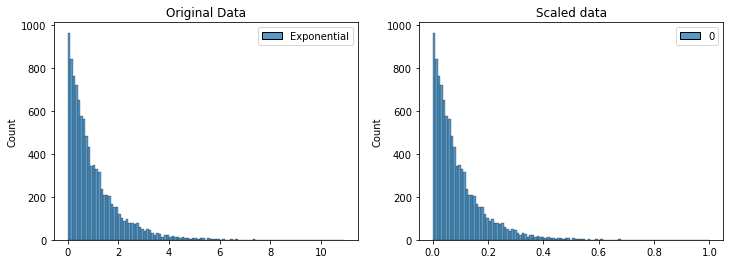

In [56]:
# 1 point
# use the min max scaler to scale your  data
original_data = df[["Exponential"]]

scaled_data = None

scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(original_data)

# plot both together to compare
fig, ax = plt.subplots(1,2, figsize=(12,4))
sb.histplot(original_data, ax=ax[0]), ax[0].set_title("Original Data")
sb.histplot(scaled_data,   ax=ax[1]), ax[1].set_title("Scaled data");

In [57]:
scaled_data

array([[0.01942359],
       [0.11912035],
       [0.23657329],
       ...,
       [0.09260184],
       [0.0407848 ],
       [0.03673496]])

In [58]:
assert scaled_data[scaled_data.argmax()] <= 1
assert scaled_data[scaled_data.argmin()] >= 0

Notice that the *shape* of the data doesn't change, but that instead of ranging from 0 to 8ish, it now ranges from 0 to 1.

# Normalization

Scaling just changes the range of your data. Normalization is a more radical transformation. The point of normalization is to change your observations so that they can be described as a normal distribution.

> **[Normal distribution:](https://en.wikipedia.org/wiki/Normal_distribution)** Also known as the "bell curve", this is a specific statistical distribution where a roughly equal observations fall above and below the mean, the mean and the median are the same, and there are more observations closer to the mean. The normal distribution is also known as the Gaussian distribution.

In general, you'll normalize your data if you're going to be using a machine learning or statistics technique that assumes your data is normally distributed. Some examples of these include linear discriminant analysis (LDA) and Gaussian naive Bayes. (Pro tip: any method with "Gaussian" in the name probably assumes normality.)

The method we're using to normalize here is called the [Box-Cox Transformation](https://en.wikipedia.org/wiki/Power_transform#Box%E2%80%93Cox_transformation). Let's take a quick peek at what normalizing some data looks like:

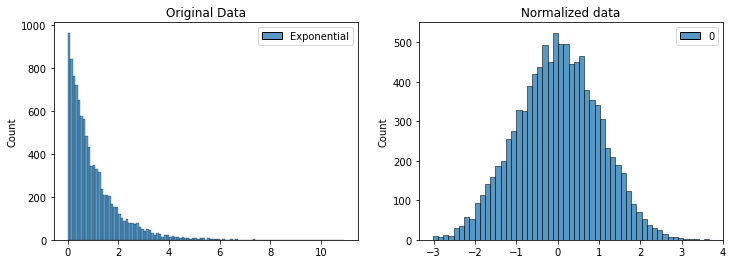

In [59]:
# 1 point

# normalize the exponential data with boxcox
normalized_data = None


original_data = df[["Exponential"]]
pt = PowerTransformer(method='box-cox')
normalized_data = pt.fit_transform(original_data)


fig, ax = plt.subplots(1,2, figsize=(12,4))
sb.histplot(original_data,    ax=ax[0]), ax[0].set_title("Original Data")
sb.histplot(normalized_data,  ax=ax[1]), ax[1].set_title("Normalized data");

In [60]:
assert normalized_data[normalized_data.argmax()] < 10
assert normalized_data[normalized_data.argmin()] > -7

Notice that the *shape* of our data has changed. Before normalizing it was almost L-shaped. But after normalizing it looks more like the outline of a bell (hence "bell curve"). 

In [61]:
# 1 point
# Get the skewness of all the samples of the original dataframe
skew = df.skew()
skew

Exponential    2.123408
Lognormal      5.282060
Chi-squared    2.763249
Weibull       -0.604515
Gaussian       0.024811
Uniform       -0.009726
Bimodal       -0.007167
dtype: float64

In [62]:
assert skew[0] > 1
assert skew[1] > 3
assert skew[2] > 1
assert -1 < skew[3] < 1
assert -1 < skew[4] < 1
assert -1 < skew[5] < 1
assert -1 < skew[6] < 1

![](https://www.allaboutcircuits.com/uploads/articles/understanding-the-normal-distribution-parametric-tests-skewness-and-kurtosis-rk-aac-image2.jpg)

In [63]:
from scipy.special import erfinv
# 5 points
# implement the rank gaussian function from the slides
def rank_gauss(x):
    n = x.shape[0] # NUmber of samples (rows)
    rank = x.argsort().argsort() # Compute Rank
    rank = rank / n # Scale to the [0,1] range
    rank = rank * 2 # Scale to the [0,2] range
    rank = rank - rank.mean() # Scale to the [-1,1] range
    efi = erfinv(rank) # Make it gaussian
    return efi

In [64]:
gauss = rank_gauss(df.Uniform)
assert gauss.shape[0] == 10000
assert gauss[gauss.argmax()] <= 4
assert gauss[gauss.argmin()] >= -4

<AxesSubplot:ylabel='Frequency'>

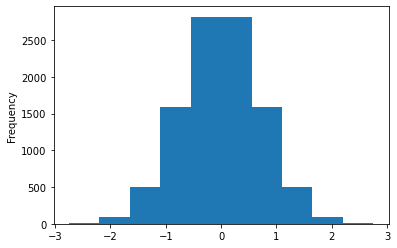

In [65]:
gauss.plot.hist()

In [66]:
# 3 points
# create a dictionary with the following enconders

encoders = {
    # Scalers
    "Min-max scaling": MinMaxScaler(),  
    "Max-abs scaling": MaxAbsScaler(),
    "Standard scaling": StandardScaler(),
    "Robust scaling":    RobustScaler(), 
    
    # Normalizers
    "Box-Cox": PowerTransformer(method='yeo-johnson'),            # Can only be used for positive values
    "Yeo-Johnson":PowerTransformer(method='yeo-johnson'),         # Similar to Box-cox but can be used for negative values.
    "Quantile (normal)":  QuantileTransformer(output_distribution='normal'),
    "Quantile (uniform)": QuantileTransformer(output_distribution='uniform')
}

In [67]:
assert type(encoders["Min-max scaling"]) is sklearn.preprocessing._data.MinMaxScaler
assert type(encoders["Max-abs scaling"]) is sklearn.preprocessing._data.MaxAbsScaler
assert type(encoders["Standard scaling"]) is sklearn.preprocessing._data.StandardScaler
assert type(encoders["Robust scaling"]) is sklearn.preprocessing._data.RobustScaler

assert type(encoders["Box-Cox"]) is sklearn.preprocessing._data.PowerTransformer
assert type(encoders["Yeo-Johnson"]) is sklearn.preprocessing._data.PowerTransformer
assert type(encoders["Quantile (normal)"]) is sklearn.preprocessing._data.QuantileTransformer
assert type(encoders["Quantile (uniform)"]) is sklearn.preprocessing._data.QuantileTransformer

Original distributions


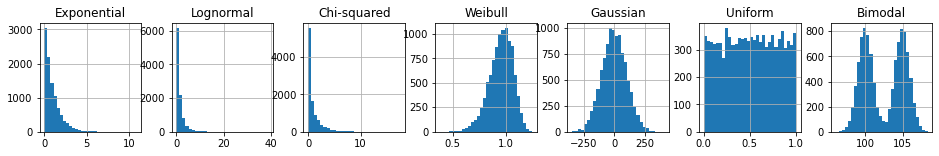

Min-max scaling


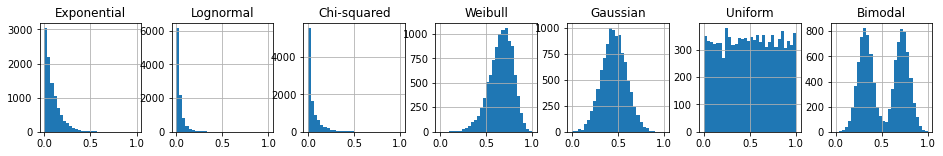

Max-abs scaling


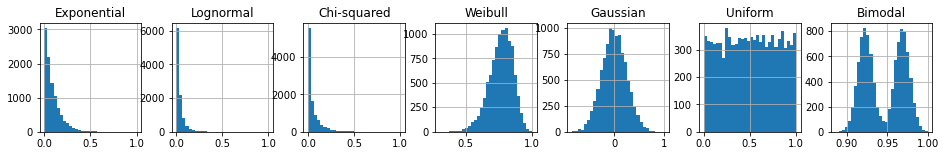

Standard scaling


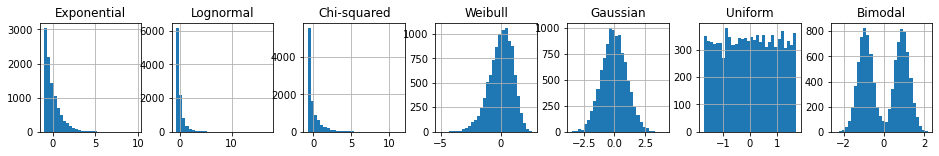

Robust scaling


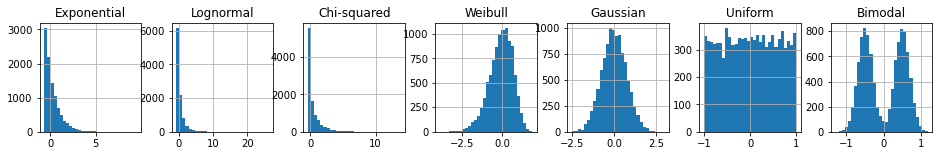

Box-Cox


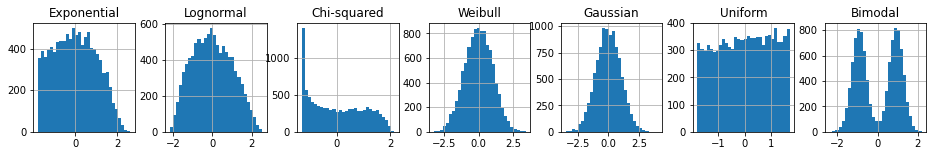

Yeo-Johnson


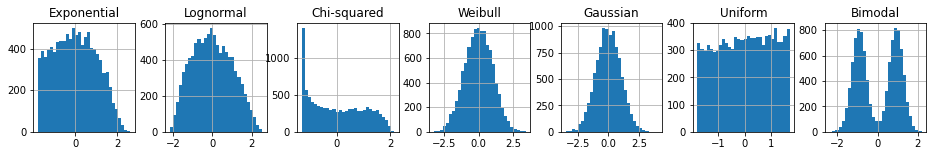

Quantile (normal)


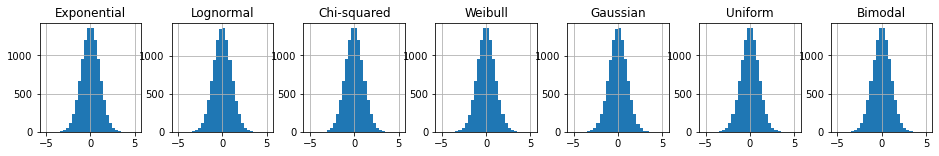

Quantile (uniform)


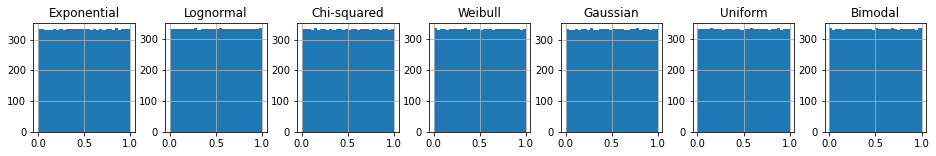

In [68]:
print("Original distributions")
df.hist(bins=BINS, layout=(1,7), figsize=(16,2))
plt.show()
for encoder_name, encoder in encoders.items():
    print(encoder_name)
    df_tmp = pd.DataFrame(encoder.fit_transform(df), columns=df.columns)
    df_tmp.hist(bins=BINS, layout=(1,7), figsize=(16,2))
    plt.show()



# Your turn

It's time to [**apply what you just learned**](https://www.kaggle.com/kernels/fork/10824404) a dataset of Kickstarter projects.